# Asociaciones falsas en presencia de varias variables

<a data-flickr-embed="true" href="https://www.flickr.com/photos/rosenfeldmedia/51202383964" title="STW024: Figure B.4"><img src="https://live.staticflickr.com/65535/51202383964_dcaef7f140_k.jpg" width="2048" height="845" alt="STW024: Figure B.4"/></a><script async src="//embedr.flickr.com/assets/client-code.js" charset="utf-8"></script>

Casi para cualquier variable de interés, podremos encontrar en muchos contextos otra variable sin relación causal alguna, que presente una correlación importante con la variable de interés. Por ejemplo, observemos la increible relación entre la cantidad de doctores en el área de ingeniería y el consumo per-cápita de queso mozzarella.

Nadie piensa que haya un mecanismo posible que haga que consumir más queso mozzarella produzca más doctorantes en ingeniería. Por lo contrario, este tipo de correlaciones nos llevan a considerar qué otras variables generan esta posible relación entre estas variables. Podríamos pensar que, por ejemplo, como resultado de una globalización masificada en los últimos años, el queso mozzarella haya llegado a países donde no era consumido; por esta misma razón, personas de lugares (países) menos favorecidos han podido migrar y lograr metas académicas destacadas.

Una vez más, la relación entre la cantidad de doctorantes de ingeniería y el consumo de queso mozzarella es simplemente un accidente; sin embargo, estos accidentes son bastante comunes. En efecto, en casi cualquier conjunto de datos grande, encontraremos correlaciones diferentes de cero entre cada par de variables. Pero siempre debemos tener presente que las correlaciones no indican relaciones causales, por lo que necesitamos herramientas para distinguir entre una simple asociación de una evidencia de causalidad.

> **Objetivos:**
> - Describir y diagnosticar el problema de asociaciones falsas.


> **Referencias:**
> 
> - Statistical Rethinking: A Bayesian Course with Examples in R and Stan (2nd edition) - Richard McElreath.

## 1. Asociaciones falsas

Un ejemplo sencillo de entender es la correlación entre la tasa de divorcios y la tasa de matrimonios.

Resulta que la tasa de matrimonios entre adultos es un buen predictor para la tasa de divorcios (correlación positiva), pero, **¿Es el divorcio causado por el matrimonio?**

En un sentido básico, claro que si. No es posible divorciarse sin antes haberse casado. Sin embargo, no hay una razón particular por la que una alta tasa de matrimonios cause más divorcios.

Otro buen predictor asociado con la tasa de divorcios es la edad mediana al momento del matrimonio (correlación negativa). En este caso, una edad más alta al momento del matrimonio indica una tasa menor de divorcios.

Los datos con los que estaremos trabajando son datos demográficos de los estados de Estados Unidos. Veamos:

In [1]:
# Importar pandas
import pandas as pd

In [3]:
# Leer WaffleDivorce data
divorce_data = pd.read_csv(
    "data/WaffleDivorce.csv",
    sep=";"
)
divorce_data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


<Axes: xlabel='Marriage', ylabel='Divorce'>

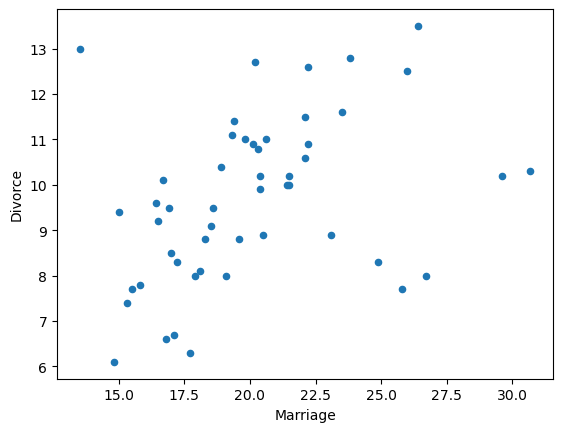

In [4]:
# Scatter: Divorce vs. Marriage
divorce_data.plot.scatter(
    x="Marriage",
    y="Divorce"
)

<Axes: xlabel='MedianAgeMarriage', ylabel='Divorce'>

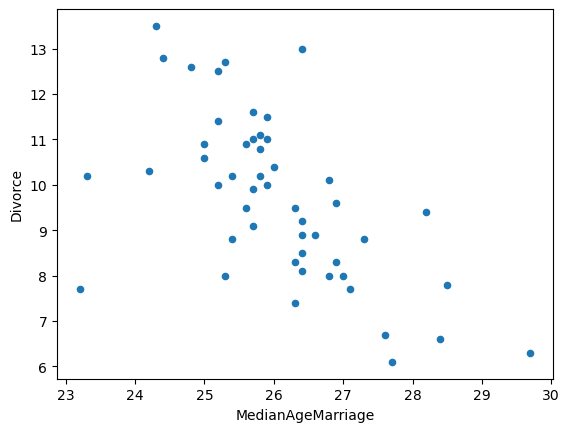

In [5]:
# Scatter: Divorce vs. MedianAgeMarriage
divorce_data.plot.scatter(
    x="MedianAgeMarriage",
    y="Divorce"
)

> ¿Quieren ver otra correlación extraña? Grafiquen la tasa de divorcios vs. el número de casas de waffles...

Antes de continuar estandaricemos los datos:

In [6]:
# Standardize function
def standardize(y: pd.Series) -> pd.Series:
    return (y - y.mean()) / y.std()

In [7]:
# Standardize variables
divorce_data["divorce_std"] = standardize(divorce_data["Divorce"])
divorce_data["marriage_std"] = standardize(divorce_data["Marriage"])
divorce_data["age_std"] = standardize(divorce_data["MedianAgeMarriage"])

Para continuar con nuestro análisis, planteamos modelos de regresión con cada una de las variables:

1. Modelo respecto a la edad:
   
   $$
   \begin{align}
   \begin{array}{lcl}
   D_i & \sim & \text{Normal}(\mu_i, \sigma) \\
   \mu_i & = & \alpha + \beta_A A_i \\
   \alpha & \sim & \text{Normal}(0, 0.2) \\
   \beta_A & \sim & \text{Normal}(0, 0.5) \\
   \sigma & \sim & \text{Exponential}(1),
   \end{array}
   \end{align}
   $$
   
   dónde $D_i$ es la tasa de divorcios estandarizada para cada estado $i$,  y $A_i$ es la edad mediana al momento del matrimonio estandarizada, para cada estado $i$.

   ¿Qué significan estas previas? Si $\beta_A=1$, esto significa que el modelo esperaría que un cambio de una desviación estándar en la edad del matrimonio (1.2 años), provoque un cambio de una desviación estándar en la tasa de divorcio (1.8%), lo que es algo extremo. Pues bien, la previa $\beta_A \sim \text{Normal}(0, 0.5)$ indica que solo se espera que el 5% de las pendientes sean más extremas que $\pm 1$.

In [9]:
# Std of MedianAgeMarriage
divorce_data["MedianAgeMarriage"].std()

1.2436303013880823

In [10]:
# Std of Divorce
divorce_data["Divorce"].std()

1.8208139018873188

In [11]:
# Importar pymc y arviz
import pymc as pm
import arviz as az

/home/esteban/anaconda3/envs/stat-rethink2-pymc_v4/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [16]:
# Age model -- sample prior predictive
with pm.Model() as age_model:
    # Priors
    a = pm.Normal("a", 0, 0.2)
    ba = pm.Normal("ba", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    # Mu
    mu = pm.Deterministic("mu", a + ba * divorce_data["age_std"])
    # Di
    divorce = pm.Normal("divorce", mu, sigma, observed=divorce_data["divorce_std"])

    # Samples
    idata_age = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, ba, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [15]:
idata_age

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

Veamos las simulaciones predictivas previas:

In [17]:
# Importar pyplot y numpy
import numpy as np
from matplotlib import pyplot as plt

In [18]:
# Simulación previa predictiva
with age_model:
    prior_pred_sim = pm.sample_prior_predictive()

Sampling: [a, ba, divorce, sigma]


In [22]:
priors_samples = az.extract_dataset(prior_pred_sim.prior)
priors_samples

/tmp/ipykernel_8816/3323544139.py:1: FutureWarning: extract_dataset has been deprecated, please use extract
  priors_samples = az.extract_dataset(prior_pred_sim.prior)


<xarray.Dataset>
Dimensions:   (sample: 500, mu_dim_0: 50)
Coordinates:
  * mu_dim_0  (mu_dim_0) int64 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * sample    (sample) object MultiIndex
  * chain     (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
  * draw      (sample) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
Data variables:
    ba        (sample) float64 0.3718 -0.1053 -0.1458 ... -0.1522 0.4057 -0.3731
    sigma     (sample) float64 0.09037 0.602 1.001 ... 0.04732 1.89 0.4341
    mu        (mu_dim_0, sample) float64 -0.7894 -0.05842 ... -0.5147 0.4696
    a         (sample) float64 -0.564 -0.1223 0.5232 ... 0.1669 0.09015 -0.0865
Attributes:
    created_at:                 2023-10-25T01:04:52.136146
    arviz_version:              0.13.0
    inference_library:          pymc
    inference_library_version:  4.3.0

Text(0, 0.5, 'Average divorce rate (std)')

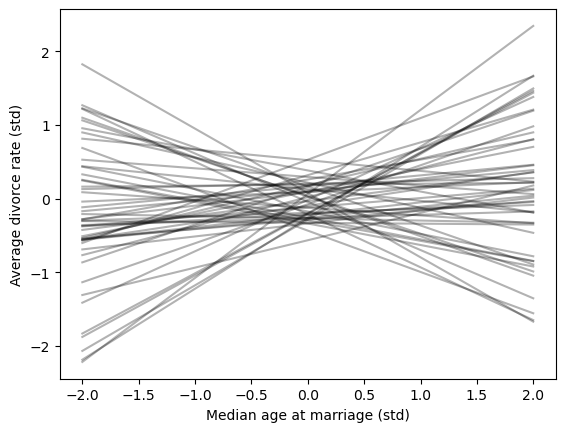

In [30]:
age = np.linspace(-2, 2, 50)

samples_a = priors_samples["a"][:50]
samples_ba = priors_samples["ba"][:50]

for a, ba in zip(samples_a, samples_ba):
    mu = a.values + ba.values * age
    plt.plot(age, mu, 'k', alpha=0.3)

plt.xlabel("Median age at marriage (std)")
plt.ylabel("Average divorce rate (std)")

Ahora, veamos las posteriores de los parámetros $\alpha$ y $\beta_A$:

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'ba'}>, <Axes: title={'center': 'ba'}>]],
      dtype=object)

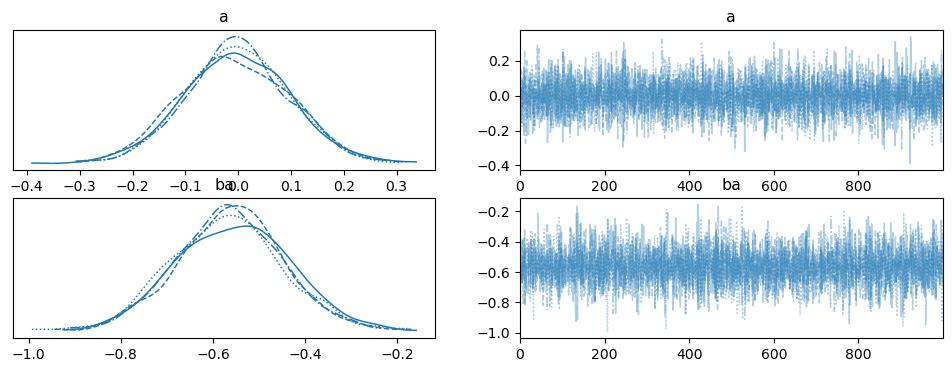

In [32]:
# plot_trace
az.plot_trace(idata_age, var_names=["a", "ba"])

In [33]:
# summary
az.summary(idata_age, var_names=["a", "ba"], kind="stats", hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,-0.003,0.099,-0.147,0.168
ba,-0.563,0.120,-0.757,-0.370


Podemos observar que $\alpha$ está alrededor de cero, mientras que $\beta_A$ es negativa.

2. Modelo respecto a la tasa de matrimonios:
   
   $$
   \begin{align}
   \begin{array}{lcl}
   D_i & \sim & \text{Normal}(\mu_i, \sigma) \\
   \mu_i & = & \alpha + \beta_M M_i \\
   \alpha & \sim & \text{Normal}(0, 0.2) \\
   \beta & \sim & \text{Normal}(0, 0.5) \\
   \sigma & \sim & \text{Exponential}(1),
   \end{array}
   \end{align}
   $$
   
   dónde $M_i$ es la tasa de matrimonio estandarizada, para cada estado $i$.

In [34]:
# Marriage model
with pm.Model() as marriage_model:
    # Priors
    a = pm.Normal("a", 0, 0.2)
    bm = pm.Normal("bm", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    # Mu
    mu = pm.Deterministic("mu", a + bm * divorce_data["marriage_std"])
    # Di
    divorce = pm.Normal("divorce", mu, sigma, observed=divorce_data["divorce_std"])

    # Samples
    idata_marriage = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bm, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'bm'}>, <Axes: title={'center': 'bm'}>]],
      dtype=object)

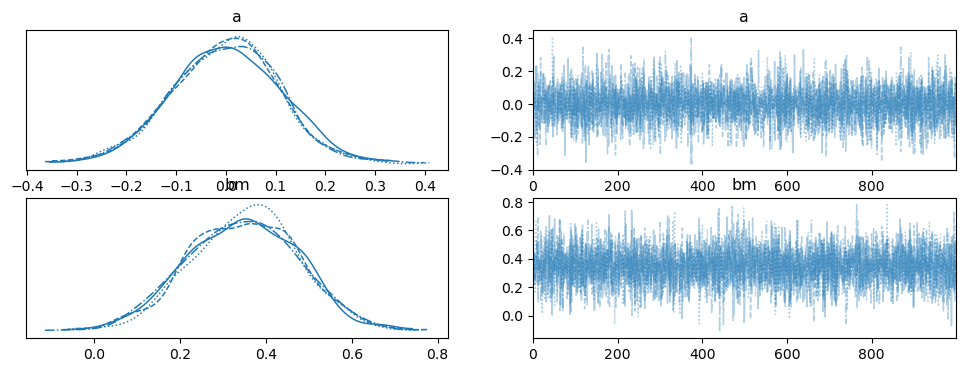

In [35]:
# plot_trace
az.plot_trace(idata_marriage, var_names=["a", "bm"])

In [36]:
# summary
az.summary(idata_marriage, var_names=["a", "bm"], kind="stats", hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,-0.001,0.108,-0.174,0.168
bm,0.348,0.130,0.155,0.566


Como podemos observar, esta relación no es tan fuerte como la anterior. Este patrón, es un síntoma de una situación en la cuál solo uno de los predictores tiene un impacto *causal* en el resultado (tasa de divorcio), incluso cuando ambas variables están asociadas fuertemente con el resultado.

### Pensemos de forma causal

Para esto, utilizamos un tipo particular de grafo, conocido como Grafo Acíclico Dirigido (DAG, por sus siglas en inglés). Un DAG, es una manera de describir de manera cualitativa las relaciones causales entre variables.

Un posible DAG para nuestro análisis es el siguiente:

In [37]:
# Importamos librerías de PGM
from causalgraphicalmodels import CausalGraphicalModel
from daft import PGM

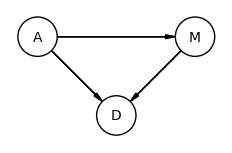

In [38]:
nodes = ["A", "D", "M"]
edges = [("A", "D"), ("A", "M"), ("M", "D")]
dag1 = CausalGraphicalModel(nodes=nodes, edges=edges)
pgm1 = PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in nodes:
    pgm1.add_node(node, node, *coordinates[node])
for edge in edges:
    pgm1.add_edge(*edge)
pgm1.render()
plt.gca().invert_yaxis()

Este diagrama, aunque simple, contiene bastante información:
- Los símbolos $A$ (edad al matrimonio), $M$ (tasa de matrimonio) y $D$ (tasa de divorcio) son nuestras variables.
- Las flechas muestran las direcciones de influencia.

Lo que este DAG dice es:
- $A$ influencia directamente a $D$.
- $M$ influencia directamente a $D$.
- $A$ influencia directamente a $M$.

Es decir, en este *modelo*, la edad al matrimonio influencia al divorcio de dos maneras:
- Una directa $A \rightarrow D$, reflejando la idea de que la gente joven "es más propensa a cambiar" y por tanto es más propensa a volverse incompatible con su pareja.
- Una indirecta $A \rightarrow M \rightarrow D$, reflejando la idea de que si las gente se casa más joven, entonces la tasa de matrimonios puede subir, afectando finalmente a la tasa de divorcios.

Para inferir **la fuerza** de estas influencias, necesitamos más de un modelo estadístico.

Nuestro primer modelo `age_model`, relacionando $D$ con $A$, nos dice que la **influencia total** de la edad al matrimonio es fuertemente negativa con la tasa de divorcio. Cuando hablamos de influencia total, nos referimos a que se toman en cuenta todos los caminos de $A$ hacia $D$ en el grafo, tanto $A \rightarrow D$ como $A \rightarrow M \rightarrow D$. Sería completamente posible, en general, que una variable como $A$ no tuviera un efecto directo en un resultado como $D$, y que toda su influencia fuera através de un efecto indirecto.

Sin embargo, este no es el caso, y el efecto indirecto no tiene mucha fuerza en este caso. ¿Cómo podemos ver esto? Pues bien, del segundo modelo `marriage_model`, la tasa de matrimonios está positivamente asociada con la tasa de divorcios. Sin embargo, esto no es suficiente para probar que la influencia $M \rightarrow D$ es positiva. Podría ser que la asociación entre $M$ y $D$ sea completamente por la influencia de $A$ en ambos:

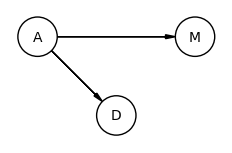

In [39]:
nodes = ["A", "D", "M"]
edges = [("A", "D"), ("A", "M")]
dag2 = CausalGraphicalModel(nodes=nodes, edges=edges)
pgm2 = PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in nodes:
    pgm2.add_node(node, node, *coordinates[node])
for edge in edges:
    pgm2.add_edge(*edge)
pgm2.render()
plt.gca().invert_yaxis()

Este grafo es completamente consistente. Es decir, dado que ambos $M$ y $D$ son influenciados por $A$, cuando exploramos la asociación entre $D$ y $M$, obtenemos la información común que se proporciona por la influencia de $A$.

Entonces, ¿Hay una influencia directa de la tasa de matrimonios $M$?, o ¿La edad al matrimonio $A$ es quien influencia a ambas variables $M$ y $D$ creando una **asociación falsa** entre la tasa de matrimonios y la tasa de divorcios?

Lo que podemos hacer es ver qué independencias condicionales codifican estos grafos:

In [40]:
dag1.get_all_independence_relationships()

[]

In [41]:
dag2.get_all_independence_relationships()

[('M', 'D', {'A'})]

De lo anterior, el primer grafo codifica que cada par de variables deberían presentar una asociación, sin importar sobre qué condicionemos.

Por otra parte, el segundo grafo codifica que cada par de variables deberían estar asociadas sin condicionar nada, **peeeero** al condicionar sobre $A$, entonces $D$ y $M$ se vuelven *condicionalmente independintes.* Es decir, al conocer la edad al matrimonio $A$, conocer la tasa de matrimonios $M$ se vuelve irrelevante para la tasa de divorcios $M$.

¿Qué podemos hacer con esto? Construyamos un tercer modelo:

3. Modelo multivariable:
   
   $$
   \begin{align}
   \begin{array}{lcl}
   D_i & \sim & \text{Normal}(\mu_i, \sigma) \\
   \mu_i & = & \alpha + \beta_M M_i + \beta_A A_i \\
   \alpha & \sim & \text{Normal}(0, 0.2) \\
   \beta_M & \sim & \text{Normal}(0, 0.5) \\
   \beta_A & \sim & \text{Normal}(0, 0.5) \\
   \sigma & \sim & \text{Exponential}(1),
   \end{array}
   \end{align}
   $$

   donde las variables tienen el mismo significado de antes.

In [42]:
# Multivariate model
with pm.Model() as multivariate_model:
    # Priors
    a = pm.Normal("a", 0, 0.2)
    bm = pm.Normal("bm", 0, 0.5)
    ba = pm.Normal("ba", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    # mu
    mu = a + bm * divorce_data["marriage_std"] + ba * divorce_data["age_std"]
    # divorce
    divorce = pm.Normal("divorce", mu, sigma, observed=divorce_data["divorce_std"])

    idata_multivariate = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bm, ba, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [43]:
# summary
az.summary(
    idata_multivariate,
    kind="stats",
    hdi_prob=0.89
)

,mean,sd,hdi_5.5%,hdi_94.5%
a,0.002,0.101,-0.163,0.164
bm,-0.065,0.160,-0.313,0.187
ba,-0.610,0.160,-0.867,-0.360
sigma,0.827,0.085,0.701,0.960


Observamos que la media de la posterior para $\beta_M$ es ahora cercana a cero, con amplia probabilidad a ambos lados del cero. Por toro lado, la media de la posterior para $\beta_A$ es similar a lo que teníamos antes.

Veamos:

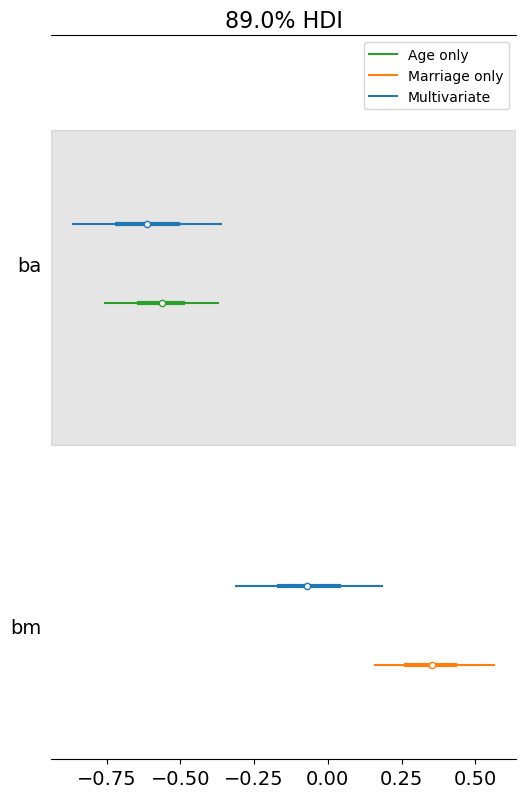

In [46]:
# plot_forest: útil para la comparación de modelos
az.plot_forest(
    [
        idata_multivariate,
        idata_marriage,
        idata_age,
    ],
    model_names=["Multivariate", "Marriage only", "Age only"],
    var_names=["ba", "bm"],
    combined=True,
    hdi_prob=0.89
);

Notamos como $\beta_A$ prácticamente no se mueve, solamente se hace un poco más incierta. Por otra parte $\beta_M$ solamente se asocia con la tasa de divorcio cuando la edad al matrimonio $A$ no está presente en el modelo. De acá que:

> Una vez conocemos la edad al matrimonio $A$, conocer la tasa de matrimonios $M$ provee poco o nada de valor predictivo. O como lo vimos anteriormente:
  $$
  D \perp M | A
  $$

Esto no quiere decir que la tasa de matrimonios $M$ no tenga valor predictivo. Si no conocieramos la edad mediana al matrimonio $A$, seguramente quisiéramos usar a $M$ como predictor. Es decir, $M$ es preditivo más no causal.

Vemos entonces que la asociación entre $M$ y $D$ es falsa, causada por la influencia de $A$ en ambas variables.